# Workshop5 : Data Warehouse with BigQuery

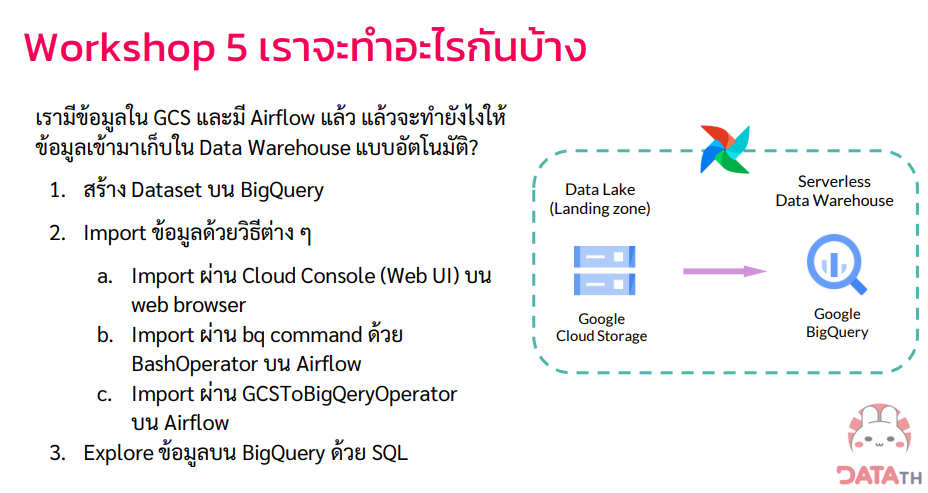

## 1. สร้าง Dataset บน BigQuery

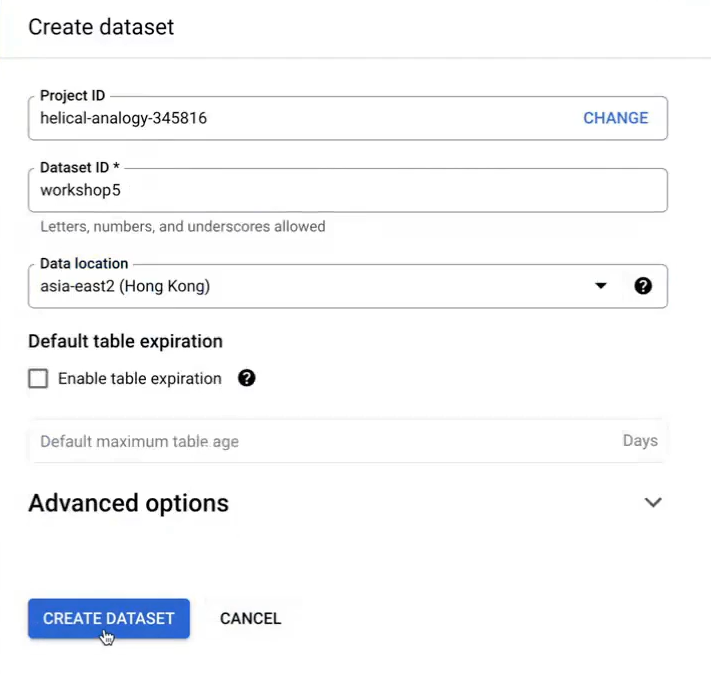

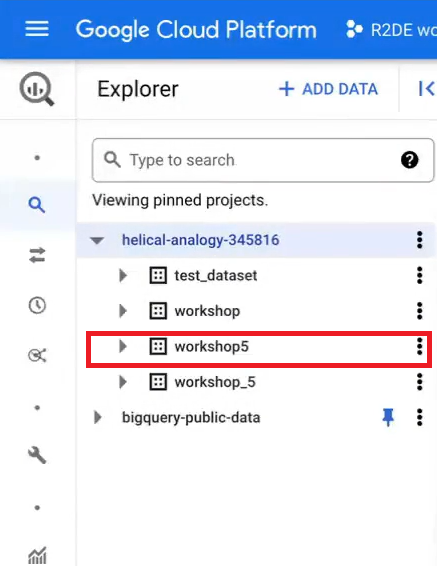

## 2. Import ข้อมูลด้วยวิธีต่าง ๆ

### a. Import ผ่าน Cloud Console (Web UI) บน web browser
* เลือกไฟล์ conversion_rate.csv โดยจะ import เข้ามาใน Dataset ชื่อว่า workshop5

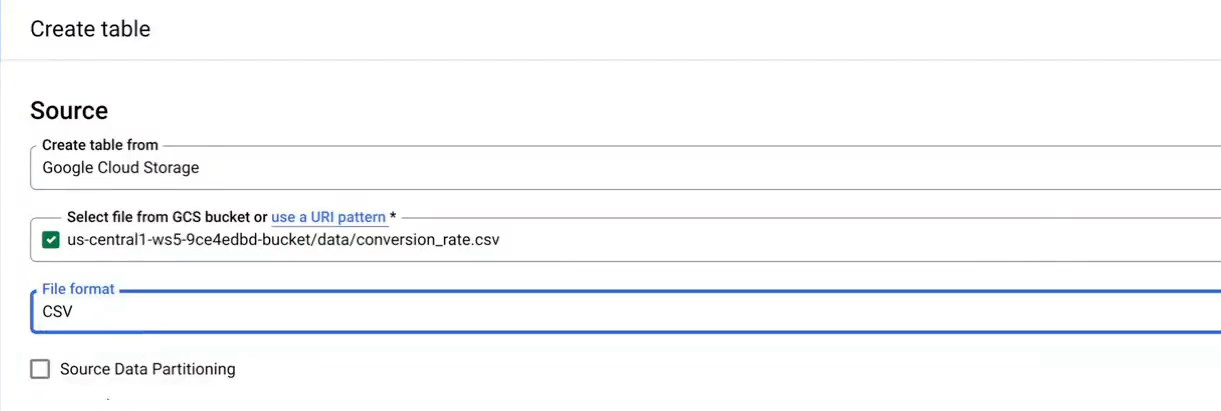

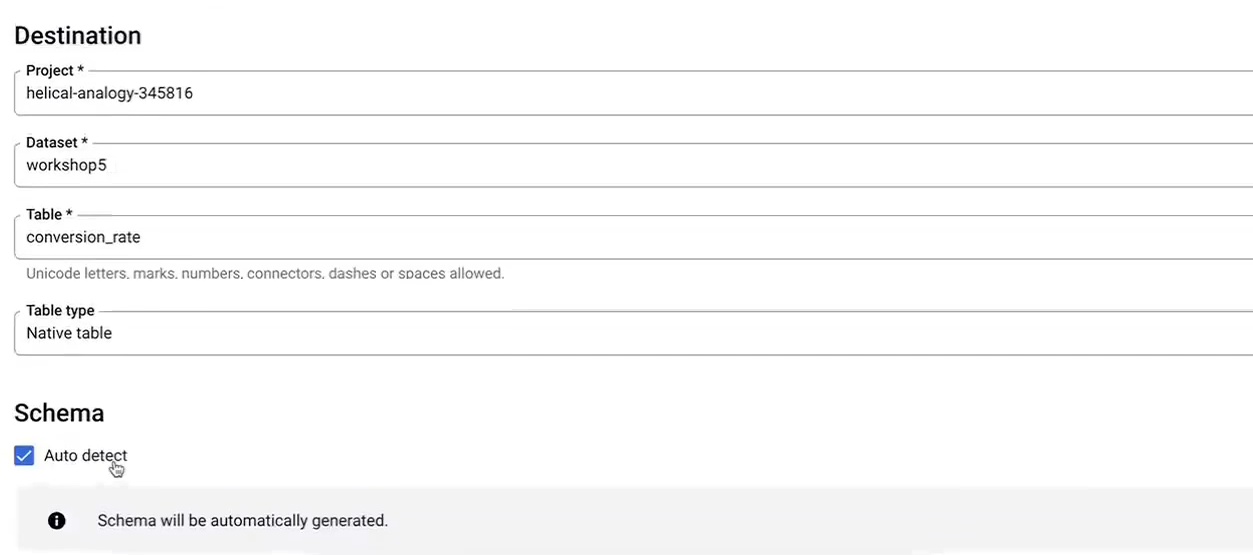

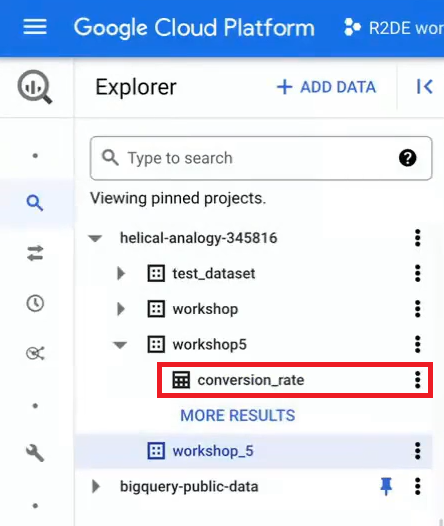

### b. Import ผ่าน bq command ด้วย BashOperator บน Airflow

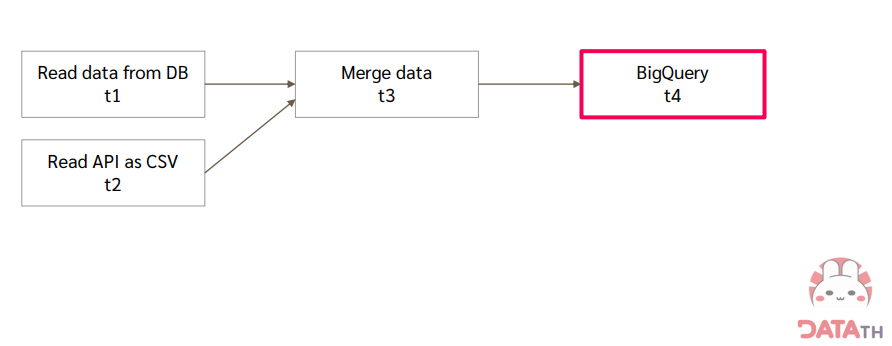

1. สร้างไฟล์ DAG ที่ cloud shell โดยใช้ชื่อไฟล์ว่า `start_ws5_bq_load`
* import ไฟล์ output.csv ที่ได้จากการ Merge data โดยจะ import เข้ามาใน Dataset ชื่อว่า workshop5 ใช้ชื่อ table คือ audible_data1

In [ ]:
from airflow.models import DAG
from airflow.operators.bash import BashOperator
from airflow.operators.python import PythonOperator
from airflow.providers.mysql.hooks.mysql import MySqlHook
from airflow.utils.dates import days_ago
import pandas as pd
import requests

MYSQL_CONNECTION = "mysql_default"   # ชื่อของ connection ใน Airflow ที่เซ็ตเอาไว้
CONVERSION_RATE_URL = "https://r2de2-workshop-vmftiryt6q-ts.a.run.app/usd_thb_conversion_rate"

# path ที่จะใช้
mysql_output_path = "/home/airflow/gcs/data/audible_data_merged.csv"
conversion_rate_output_path = "/home/airflow/gcs/data/conversion_rate.csv"
final_output_path = "/home/airflow/gcs/data/output.csv"


def get_data_from_mysql(transaction_path):
    # รับ transaction_path มาจาก task ที่เรียกใช้

    # เรียกใช้ MySqlHook เพื่อต่อไปยัง MySQL จาก connection ที่สร้างไว้ใน Airflow
    mysqlserver = MySqlHook(MYSQL_CONNECTION)

    # Query จาก database โดยใช้ Hook ที่สร้าง ผลลัพธ์ได้ pandas DataFrame
    audible_data = mysqlserver.get_pandas_df(sql="SELECT * FROM audible_data")
    audible_transaction = mysqlserver.get_pandas_df(sql="SELECT * FROM audible_transaction")

    # Merge data จาก 2 DataFrame เหมือนใน workshop1
    df = audible_transaction.merge(audible_data, how="left", left_on="book_id", right_on="Book_ID")

    # Save ไฟล์ CSV ไปที่ transaction_path ("/home/airflow/gcs/data/audible_data_merged.csv")
    # จะไปอยู่ที่ GCS โดยอัตโนมัติ
    df.to_csv(transaction_path, index=False)
    print(f"Output to {transaction_path}")


def get_conversion_rate(conversion_rate_path):
    r = requests.get(CONVERSION_RATE_URL)
    result_conversion_rate = r.json()
    df = pd.DataFrame(result_conversion_rate)

    # เปลี่ยนจาก index ที่เป็น date ให้เป็น column ชื่อ date แทน แล้วเซฟไฟล์ CSV
    df = df.reset_index().rename(columns={"index": "date"})
    df.to_csv(conversion_rate_path, index=False)
    print(f"Output to {conversion_rate_path}")


def merge_data(transaction_path, conversion_rate_path, output_path):
    # อ่านจากไฟล์ สังเกตว่าใช้ path จากที่รับ parameter มา
    transaction = pd.read_csv(transaction_path)
    conversion_rate = pd.read_csv(conversion_rate_path)

    transaction['date'] = transaction['timestamp']
    transaction['date'] = pd.to_datetime(transaction['date']).dt.date
    conversion_rate['date'] = pd.to_datetime(conversion_rate['date']).dt.date

    # merge 2 DataFrame
    final_df = transaction.merge(conversion_rate, how="left", left_on="date", right_on="date")

    # แปลงราคา โดยเอาเครื่องหมาย $ ออก และแปลงให้เป็น float
    final_df["Price"] = final_df.apply(lambda x: x["Price"].replace("$",""), axis=1)
    final_df["Price"] = final_df["Price"].astype(float)

    final_df["THBPrice"] = final_df["Price"] * final_df["conversion_rate"]
    final_df = final_df.drop(["date", "book_id"], axis=1)

    # save ไฟล์ CSV
    final_df.to_csv(output_path, index=False)
    print(f"Output to {output_path}")
    print("== End of Workshop 4 ʕ•́ᴥ•̀ʔっ♡ ==")


with DAG(
    "workshop5_bq_load_dag",
    start_date=days_ago(1),
    schedule_interval="@once",
    tags=["workshop"]
) as dag:

    dag.doc_md = """
    # Workshop5: Load to BigQuery ด้วยคำสั่ง bq load
    bq command เป็น command-line tool ที่สามารถใช้จัดการกับ BigQuery ได้
    ดูเพิ่มเติมได้ที่นี่ https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv#loading_csv_data_into_a_table
    """

    t1 = PythonOperator(
        task_id="get_data_from_mysql",
        python_callable=get_data_from_mysql,
        op_kwargs={"transaction_path": mysql_output_path},
    )

    t2 = PythonOperator(
        task_id="get_conversion_rate",
        python_callable=get_conversion_rate,
        op_kwargs={"conversion_rate_path": conversion_rate_output_path},
    )

    t3 = PythonOperator(
        task_id="merge_data",
        python_callable=merge_data,
        op_kwargs={
            "transaction_path": mysql_output_path,
            "conversion_rate_path": conversion_rate_output_path,
            "output_path": final_output_path
        },
    )

    # TODO: สร้าง t4 ที่เป็น BashOperator เพื่อใช้งานกับ BigQuery และใส่ dependencies

    t4 = BashOperator(
        task_id="load_to_bq",
        bash_command="bq load --source_format=CSV --autodetect workshop5.audible_data1 gs://asia-east2-workshop5-03d65f08-bucket/data/output.csv"
    )

    [t1, t2] >> t3 >> t4


2. Upload ไฟล์ DAG เข้าสู่ bucket ที่เชื่อมต่อกับ Cloud Composer
```
gsutil cp [FILE] gs://[CLOUD_COMPOSER_BUCKET]/dags/
```

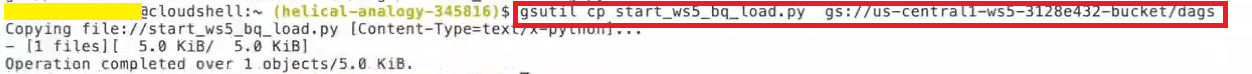

3. เข้าไปดูที่ airflow เพื่อดูผลลัพธ์

* run task เสร็จเรียบร้อย

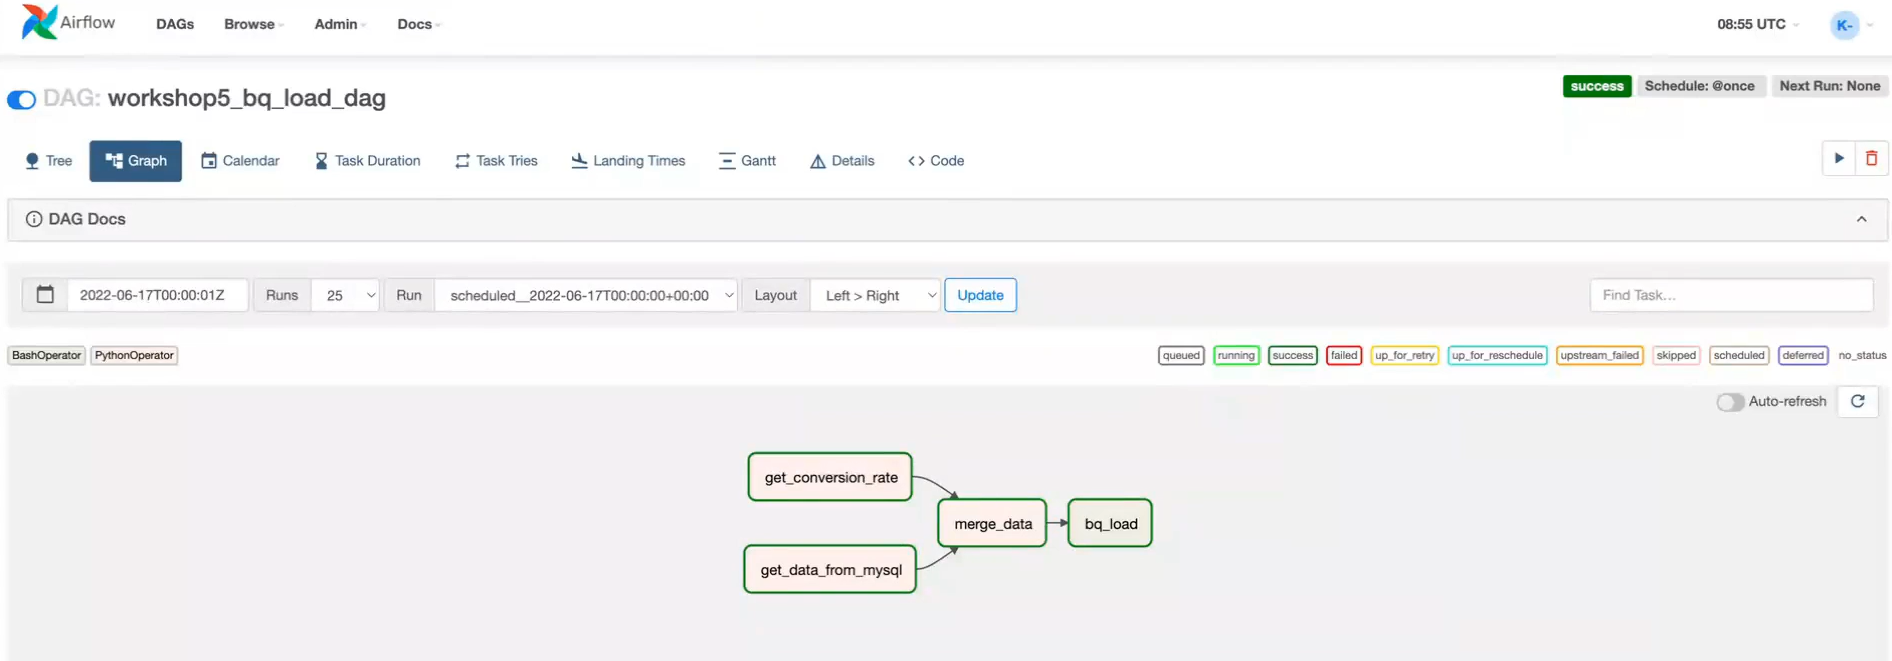

4. เข้าไปดูที่ BigQuery เพื่อดูผลลัพธ์

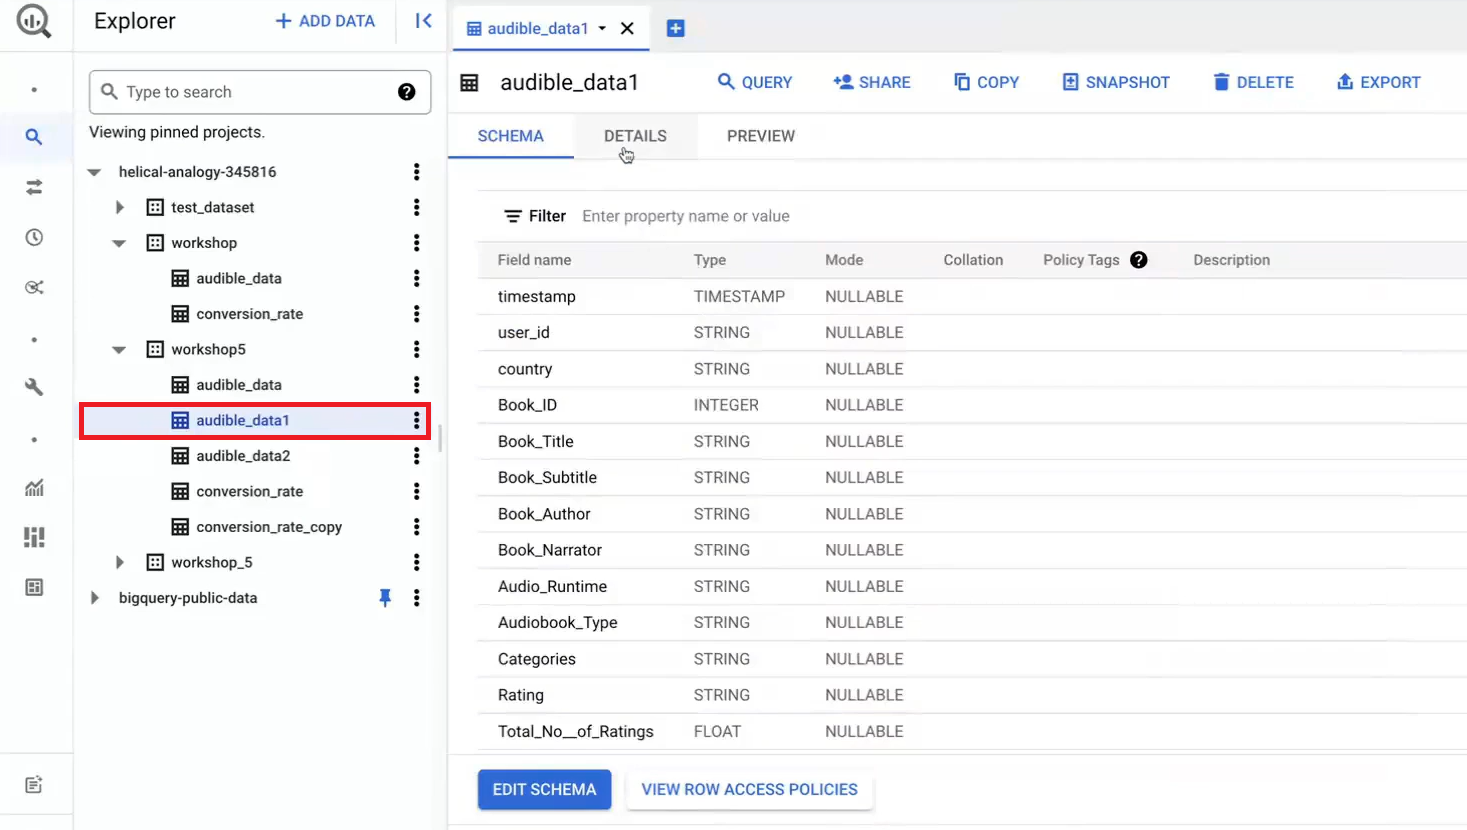

### c. Import ผ่าน GCSToBigQeryOperator บน Airflow

* Operator อื่นๆ https://airflow.apache.org/docs/apache-airflow-providers-google/stable/operators/cloud/gcs.html

1. สร้างไฟล์ DAG ที่ cloud shell โดยใช้ชื่อไฟล์ว่า `start_ws5_gcs_to_bq`
* import ไฟล์ output.csv ที่ได้จากการ Merge data โดยจะ import เข้ามาใน Dataset ชื่อว่า workshop5 ใช้ชื่อ table คือ audible_data2

In [ ]:
from airflow.models import DAG
from airflow.operators.bash import BashOperator
from airflow.operators.python import PythonOperator
from airflow.providers.google.cloud.transfers.gcs_to_bigquery import GCSToBigQueryOperator
from airflow.providers.mysql.hooks.mysql import MySqlHook
from airflow.utils.dates import days_ago
import pandas as pd
import requests

MYSQL_CONNECTION = "mysql_default"   # ชื่อของ connection ใน Airflow ที่เซ็ตเอาไว้
CONVERSION_RATE_URL = "https://r2de2-workshop-vmftiryt6q-ts.a.run.app/usd_thb_conversion_rate"

# path ที่จะใช้
mysql_output_path = "/home/airflow/gcs/data/audible_data_merged.csv"
conversion_rate_output_path = "/home/airflow/gcs/data/conversion_rate.csv"
final_output_path = "/home/airflow/gcs/data/output.csv"


def get_data_from_mysql(transaction_path):
    # รับ transaction_path มาจาก task ที่เรียกใช้

    # เรียกใช้ MySqlHook เพื่อต่อไปยัง MySQL จาก connection ที่สร้างไว้ใน Airflow
    mysqlserver = MySqlHook(MYSQL_CONNECTION)

    # Query จาก database โดยใช้ Hook ที่สร้าง ผลลัพธ์ได้ pandas DataFrame
    audible_data = mysqlserver.get_pandas_df(sql="SELECT * FROM audible_data")
    audible_transaction = mysqlserver.get_pandas_df(sql="SELECT * FROM audible_transaction")

    # Merge data จาก 2 DataFrame เหมือนใน workshop1
    df = audible_transaction.merge(audible_data, how="left", left_on="book_id", right_on="Book_ID")

    # Save ไฟล์ CSV ไปที่ transaction_path ("/home/airflow/gcs/data/audible_data_merged.csv")
    # จะไปอยู่ที่ GCS โดยอัตโนมัติ
    df.to_csv(transaction_path, index=False)
    print(f"Output to {transaction_path}")


def get_conversion_rate(conversion_rate_path):
    r = requests.get(CONVERSION_RATE_URL)
    result_conversion_rate = r.json()
    df = pd.DataFrame(result_conversion_rate)

    # เปลี่ยนจาก index ที่เป็น date ให้เป็น column ชื่อ date แทน แล้วเซฟไฟล์ CSV
    df = df.reset_index().rename(columns={"index": "date"})
    df.to_csv(conversion_rate_path, index=False)
    print(f"Output to {conversion_rate_path}")


def merge_data(transaction_path, conversion_rate_path, output_path):
    # อ่านจากไฟล์ สังเกตว่าใช้ path จากที่รับ parameter มา
    transaction = pd.read_csv(transaction_path)
    conversion_rate = pd.read_csv(conversion_rate_path)

    transaction['date'] = transaction['timestamp']
    transaction['date'] = pd.to_datetime(transaction['date']).dt.date
    conversion_rate['date'] = pd.to_datetime(conversion_rate['date']).dt.date

    # merge 2 DataFrame
    final_df = transaction.merge(conversion_rate, how="left", left_on="date", right_on="date")

    # แปลงราคา โดยเอาเครื่องหมาย $ ออก และแปลงให้เป็น float
    final_df["Price"] = final_df.apply(lambda x: x["Price"].replace("$",""), axis=1)
    final_df["Price"] = final_df["Price"].astype(float)

    final_df["THBPrice"] = final_df["Price"] * final_df["conversion_rate"]
    final_df = final_df.drop(["date", "book_id"], axis=1)

    # save ไฟล์ CSV
    final_df.to_csv(output_path, index=False)
    print(f"Output to {output_path}")
    print("== End of Workshop 4 ʕ•́ᴥ•̀ʔっ♡ ==")


with DAG(
    "workshop5_gcs_to_bq_dag",
    start_date=days_ago(1),
    schedule_interval="@once",
    tags=["workshop"]
) as dag:

    dag.doc_md = """
    # Workshop5: Load to BigQuery ด้วยคำสั่ง GCSToBigQueryOperator ของ Airflow
    เหมาะสำหรับ worker ที่ไม่มี bq command
    Documentation : https://airflow.apache.org/docs/apache-airflow-providers-google/stable/operators/cloud/gcs.html
    Example: https://airflow.apache.org/docs/apache-airflow-providers-google/stable/_modules/airflow/providers/google/cloud/example_dags/example_gcs_to_bigquery.html
    """

    t1 = PythonOperator(
        task_id="get_data_from_mysql",
        python_callable=get_data_from_mysql,
        op_kwargs={"transaction_path": mysql_output_path},
    )

    t2 = PythonOperator(
        task_id="get_conversion_rate",
        python_callable=get_conversion_rate,
        op_kwargs={"conversion_rate_path": conversion_rate_output_path},
    )

    t3 = PythonOperator(
        task_id="merge_data",
        python_callable=merge_data,
        op_kwargs={
            "transaction_path": mysql_output_path,
            "conversion_rate_path": conversion_rate_output_path,
            "output_path": final_output_path
        },
    )

    # TODO: สร้าง t4 ที่เป็น GCSToBigQueryOperator เพื่อใช้งานกับ BigQuery แบบ Airflow และใส่ dependencies

    t4 = GCSToBigQueryOperator(
        task_id='gcs_to_bq',
        bucket='asia-east2-workshop5-03d65f08-bucket',
        source_objects=['data/output.csv'],
        destination_project_dataset_table='workshop5.audible_data2',
        skip_leading_rows=1,
        schema_fields=[
            {
                "mode": "NULLABLE",
                "name": "timestamp",
                "type": "TIMESTAMP"
            },
            {
                "mode": "NULLABLE",
                "name": "user_id",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "country",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_ID",
                "type": "INTEGER"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Title",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Subtitle",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Author",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Narrator",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Audio_Runtime",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Audiobook_Type",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Categories",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Rating",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Total_No__of_Ratings",
                "type": "FLOAT"
            },
            {
                "mode": "NULLABLE",
                "name": "Price",
                "type": "FLOAT"
            },
            {
                "mode": "NULLABLE",
                "name": "conversion_rate",
                "type": "FLOAT"
            },
            {
                "mode": "NULLABLE",
                "name": "THBPrice",
                "type": "FLOAT"
            }
        ],
        write_disposition='WRITE_TRUNCATE',
    )

    [t1, t2] >> t3 >> t4


2. Upload ไฟล์ DAG เข้าสู่ bucket ที่เชื่อมต่อกับ Cloud Composer โดยใช้ UI ในการ Upload

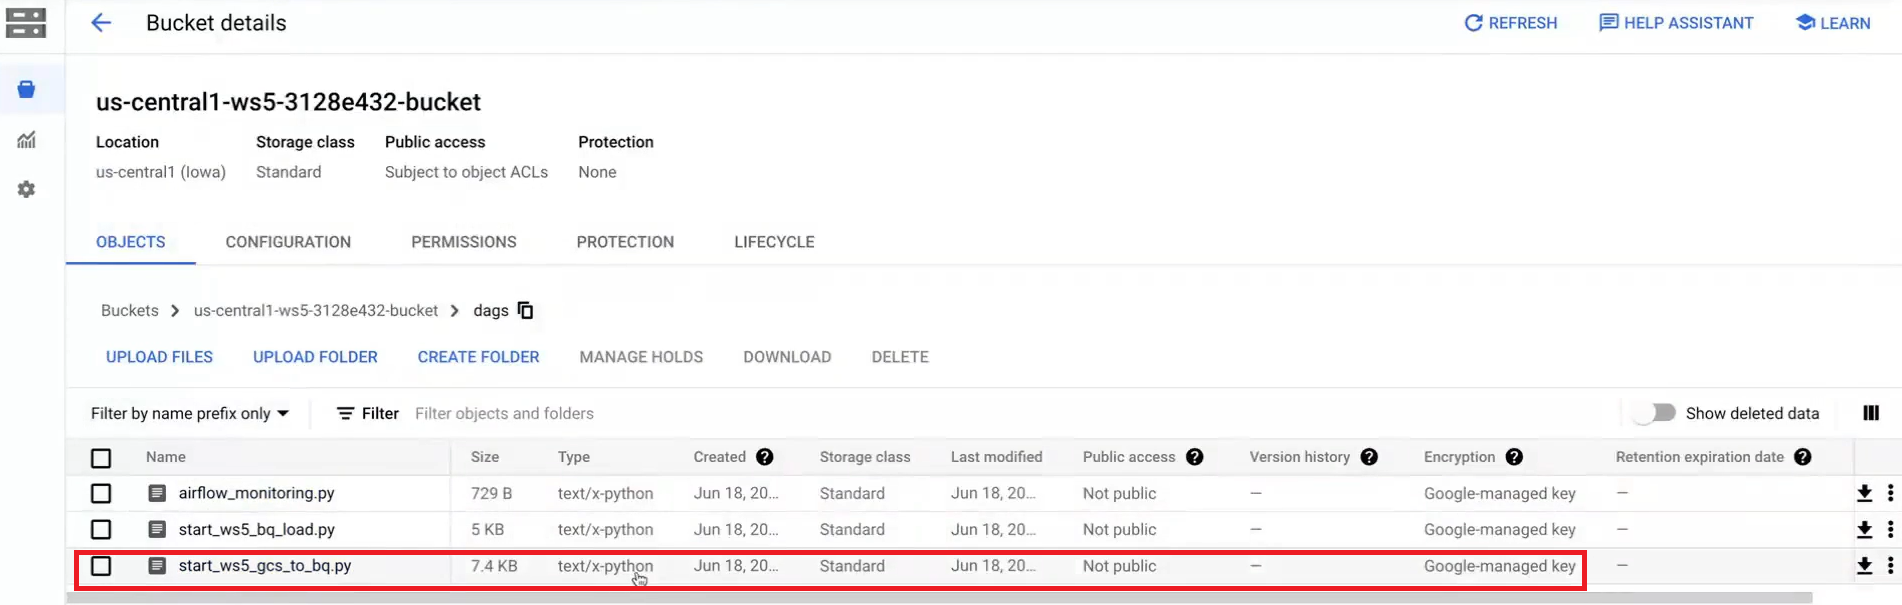

3. เข้าไปดูที่ airflow เพื่อดูผลลัพธ์

* run task เสร็จเรียบร้อย

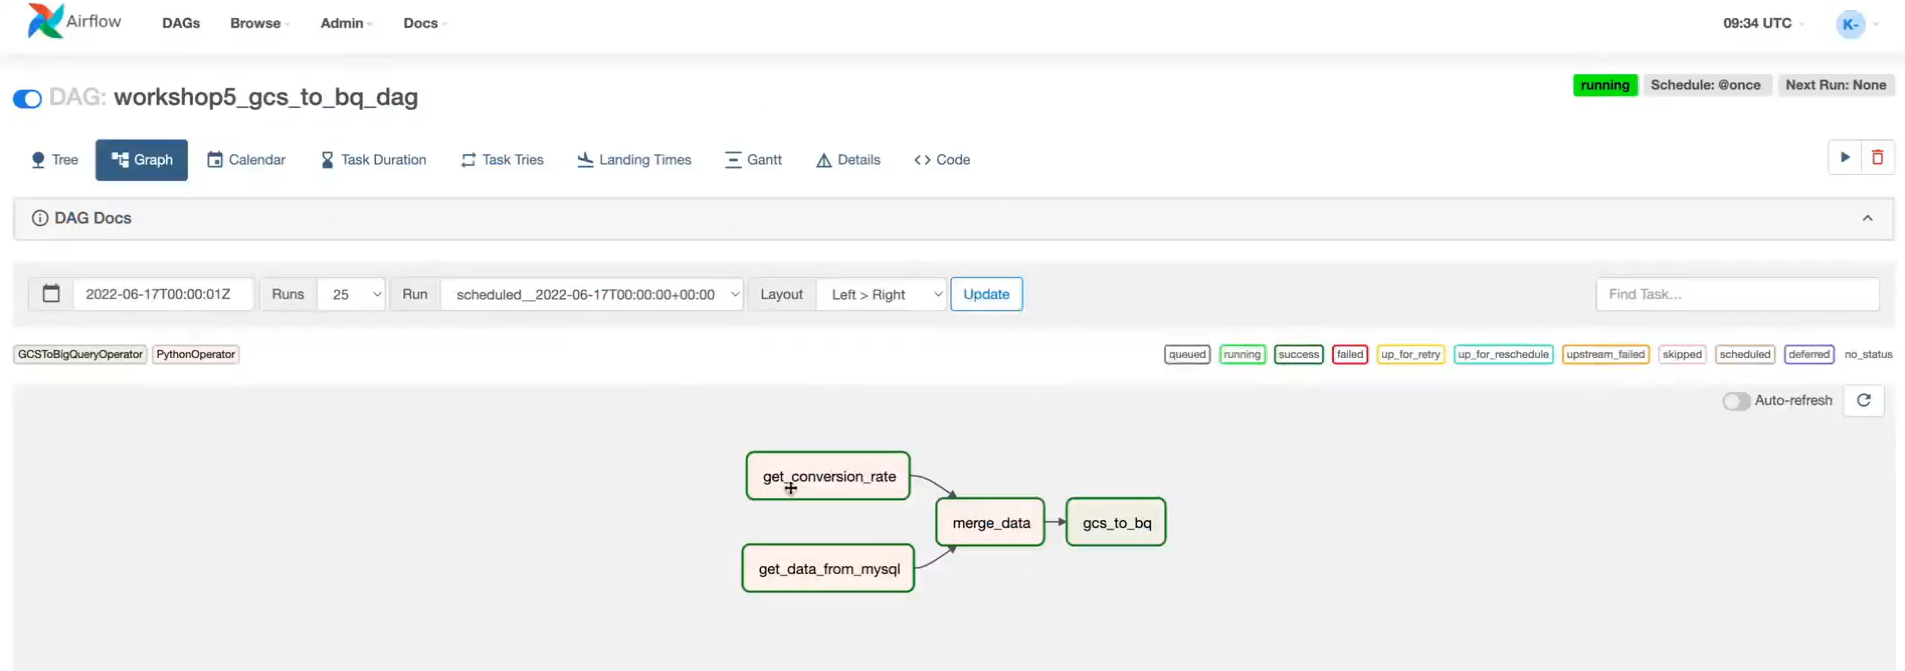

4. เข้าไปดูที่ BigQuery เพื่อดูผลลัพธ์

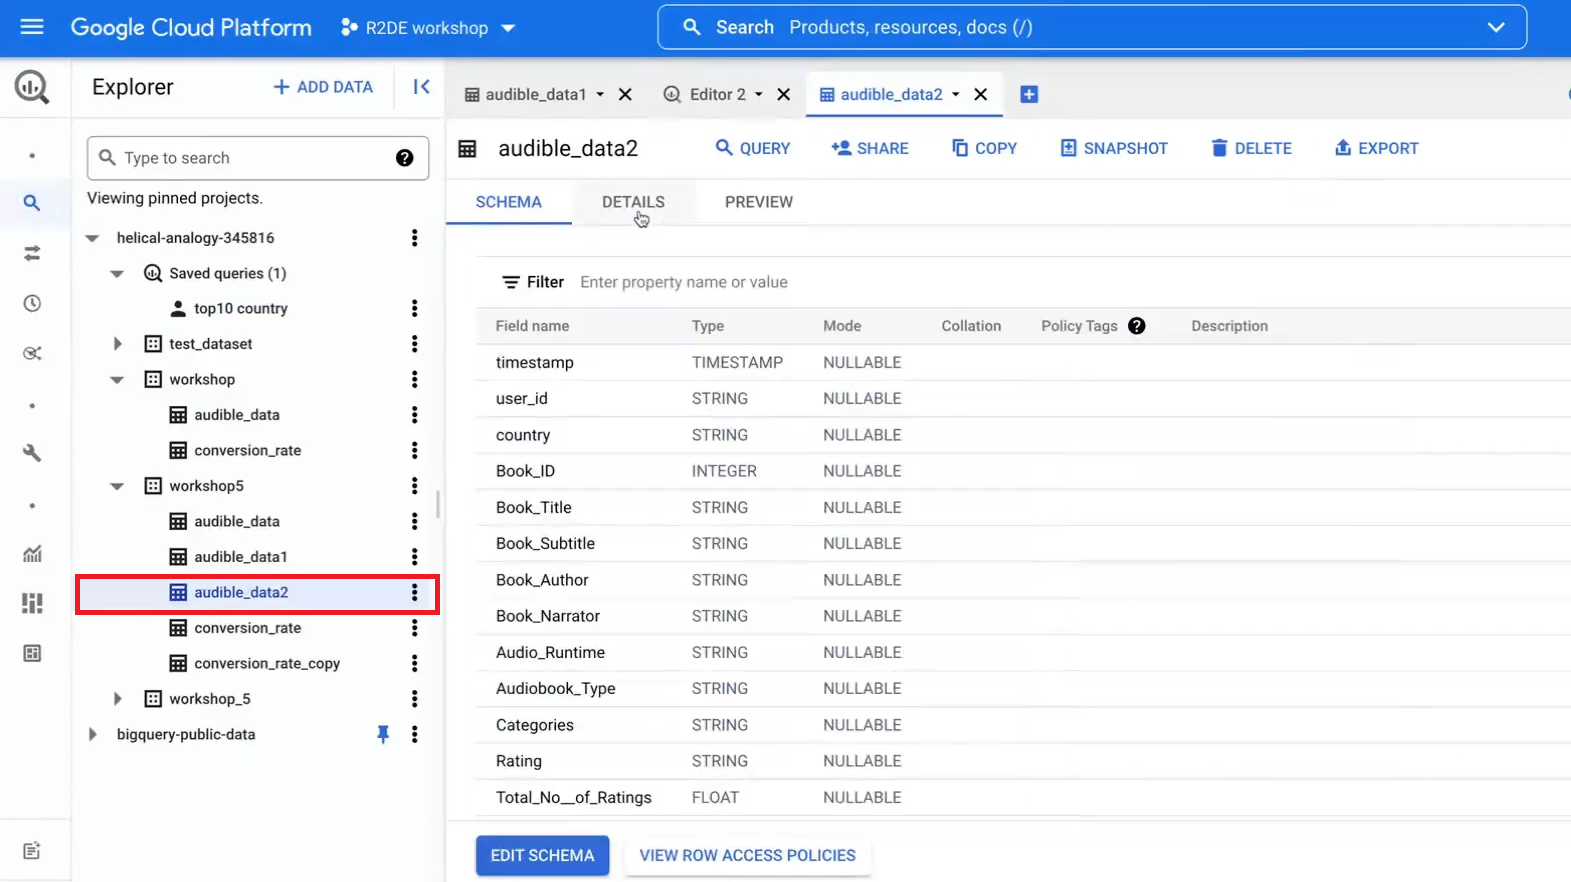

## 3. Explore ข้อมูลบน BigQuery ด้วย SQL

* ลองหา Transactions ในแต่ละประเทศ โดยเรียงจากมากไปน้อย โดยแสดงข้อมูลแค่ 10 ประเทศ

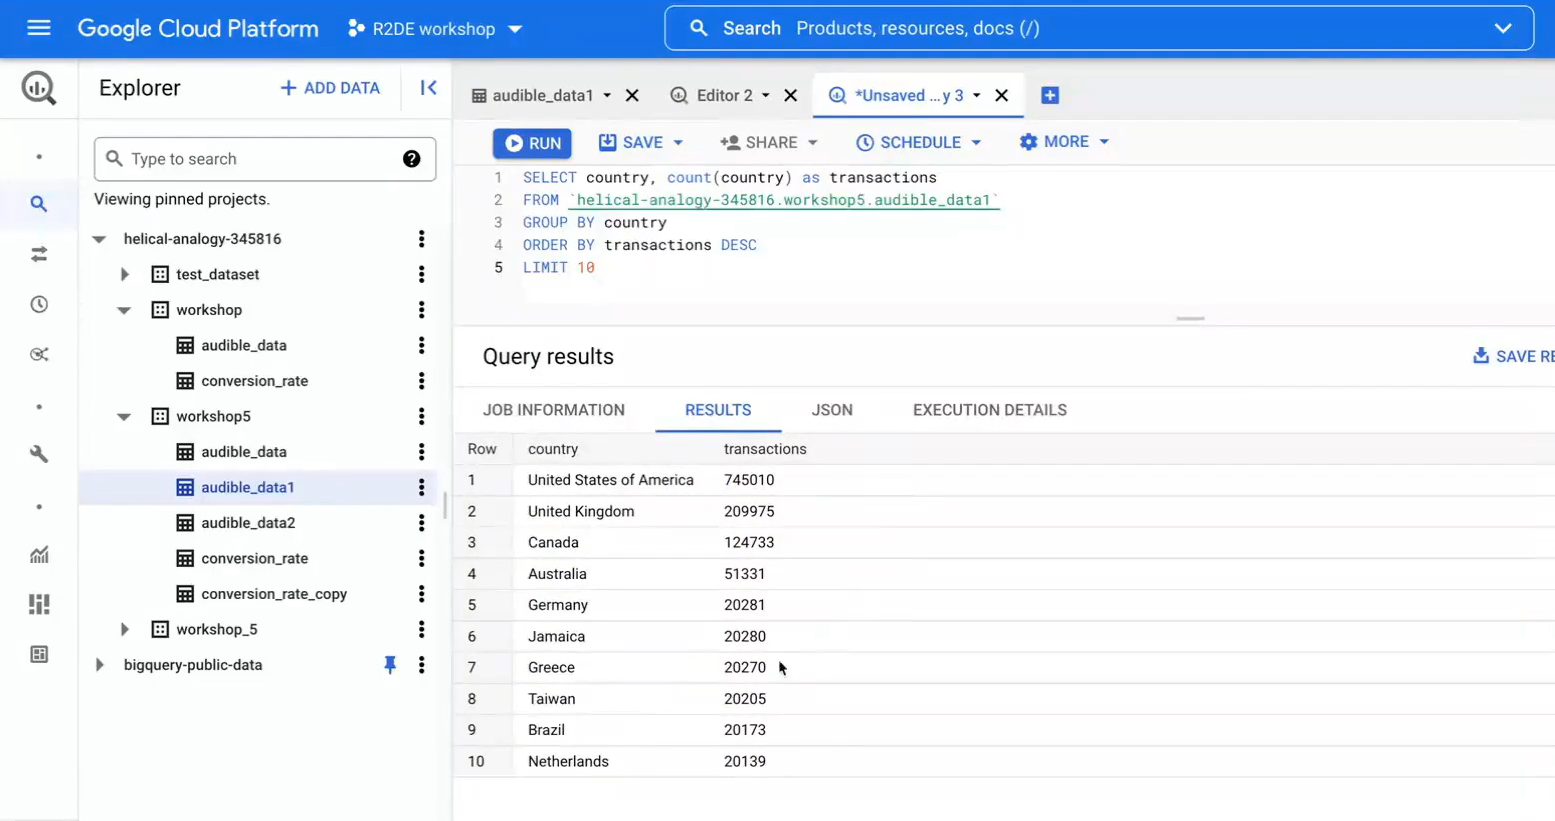